Here we will show an example of how to run deepblast on simulation data.

In [1]:
import os
from deepblast.sim import hmm_alignments
import argparse
import numpy as np

We will first simulate multiple sequences from a single PFam family.
The resulting generated alignments will be used to train the model.

In [2]:
hmm = '../data/zf-C2H2.hmm'
n_alignments = 100
np.random.seed(0)
align_df = hmm_alignments(n=40, seed=0, n_alignments=n_alignments, hmmfile=hmm)

cols = [
    'chain1_name', 'chain2_name', 'tmscore1', 'tmscore2', 'rmsd',
    'chain1', 'chain2', 'alignment'
]
align_df.columns = cols

The simulated alignments will be split into training / testing and validation.

In [3]:
parts = n_alignments // 10
train_df = align_df.iloc[:parts * 8]
test_df = align_df.iloc[parts * 8:parts * 9]
valid_df = align_df.iloc[parts * 9:]

# save the files to disk.
train_df.to_csv('data/train.txt', sep='\t', index=None, header=None)
test_df.to_csv('data/test.txt', sep='\t', index=None, header=None)
valid_df.to_csv('data/valid.txt', sep='\t', index=None, header=None)

We will prepare the environment to make sure that the appropriate output directories exist to store the results.

In [4]:
from deepblast.trainer import LightningAligner
from pytorch_lightning import Trainer

output_dir = 'simulation_results'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [5]:
os.getcwd()

'/home/juermieboop/Documents/research/garfunkel/ipynb'

We will now create the arguments.  Below is the way to create this in a python environment.
This can also be recreated on a standard command line interface.

In [6]:
args = [
    '--train-pairs', f'{os.getcwd()}/data/train.txt',
    '--test-pairs', f'{os.getcwd()}/data/test.txt',
    '--valid-pairs', f'{os.getcwd()}/data/valid.txt',
    '--output-directory', output_dir,
    '--epochs', '32',
    '--batch-size', '20',   
    '--num-workers', '30',
    '--learning-rate', '1e-4',
    '--layers', '2',
    '--visualization-fraction', '1',
    '--loss', 'cross_entropy',
    '--scheduler', 'cosine',
    '--gpus', '1'
]
parser = argparse.ArgumentParser(add_help=False)
parser = LightningAligner.add_model_specific_args(parser)
parser.add_argument('--num-workers', type=int)
parser.add_argument('--gpus', type=int)
args = parser.parse_args(args)

In [7]:
%tb

No traceback available to show.


We will then initialize the alignment model with the parameters we specified earlier.

In [8]:
model = LightningAligner(args)

We can now train the model.

In [9]:
trainer = Trainer(
    max_epochs=args.epochs,
    gpus=args.gpus,
    check_val_every_n_epoch=1,
    # profiler=profiler,
    fast_dev_run=False,
    # auto_scale_batch_size='power'
)

trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
/home/juermieboop/miniconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name    | Type                   | Params
---------------------------------------------------
0 | aligner | NeedlemanWunschAligner | 34 M  


Saving latest checkpoint..


1

The model diagnostics can be directly visualized in Tensorboard. Here, we show the losses, the accuracy and the alignment results.

In [10]:
!ls lightning_logs

version_0   version_13	version_18  version_22	version_27  version_5
version_1   version_14	version_19  version_23	version_28  version_6
version_10  version_15	version_2   version_24	version_29  version_7
version_11  version_16	version_20  version_25	version_3   version_8
version_12  version_17	version_21  version_26	version_4   version_9


In [16]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [17]:
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6007 (pid 72107), started 1:58:10 ago. (Use '!kill 72107' to kill it.)

And we did this with just a few million parameters

In [13]:
model.aligner

NeedlemanWunschAligner(
  (lm): BiLM(
    (embed): Embedding(22, 21, padding_idx=21)
    (dropout): Dropout(p=0, inplace=False)
    (rnn): ModuleList(
      (0): LSTM(21, 1024, batch_first=True)
      (1): LSTM(1024, 1024, batch_first=True)
    )
    (linear): Linear(in_features=1024, out_features=21, bias=True)
  )
  (match_embedding): StackedRNN(
    (embed): Embedding(21, 512, padding_idx=20)
    (dropout): Dropout(p=0, inplace=False)
    (rnn): LSTM(512, 512, num_layers=2, batch_first=True, bidirectional=True)
    (proj): Linear(in_features=1024, out_features=512, bias=True)
  )
  (gap_embedding): StackedRNN(
    (embed): Embedding(21, 512, padding_idx=20)
    (dropout): Dropout(p=0, inplace=False)
    (rnn): LSTM(512, 512, num_layers=2, batch_first=True, bidirectional=True)
    (proj): Linear(in_features=1024, out_features=512, bias=True)
  )
  (nw): NeedlemanWunschDecoder()
)

In [18]:
!ls lightning_logs/version_29/checkpoints

'epoch=25.ckpt'


In [19]:
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
checkpoint_dir = 'lightning_logs/version_29/checkpoints'
path = f'{checkpoint_dir}/epoch=25.ckpt'
model = LightningAligner.load_from_checkpoint(path)

In [20]:
from deepblast.dataset.dataset import states2matrix, tmstate_f
import numpy as np
import torch
from torch.nn.utils.rnn import pack_sequence
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
i = 9
test = align_df
x = str.encode(test.iloc[i]['chain1'])
y = str.encode(test.iloc[i]['chain2'])
states = test.iloc[i]['alignment']
x_ = torch.Tensor(model.tokenizer(x)).long().unsqueeze(0)
y_ = torch.Tensor(model.tokenizer(y)).long().unsqueeze(0)
x_ = pack_sequence(x_, enforce_sorted=False).cuda()
y_ = pack_sequence(y_, enforce_sorted=False).cuda()
states = list(map(tmstate_f, states))
A = states2matrix(states)

In [22]:
model = model.cuda()
aln, theta, gap = model.forward(x_, y_)

NameError: name 'y' is not defined

NameError: name 'aln' is not defined

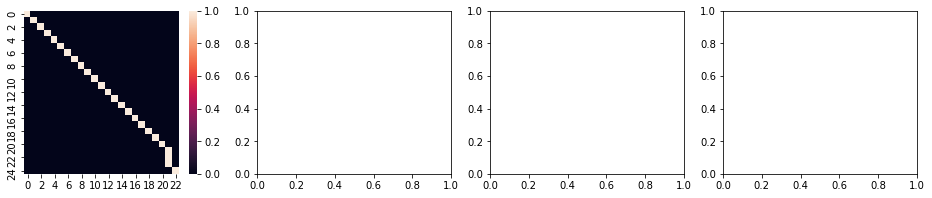

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
sns.heatmap(A, ax=ax[0])
sns.heatmap(aln.cpu().detach().numpy().squeeze(), ax=ax[1])
sns.heatmap(np.log(theta.cpu().detach().numpy().squeeze()), ax=ax[2])
sns.heatmap(gap.cpu().detach().numpy().squeeze(), ax=ax[3])

In [24]:
from deepblast.dataset.alphabet import Uniprot21
from deepblast.dataset.dataset import decode
from deepblast.score import alignment_text, roc_edges

ImportError: cannot import name 'decode' from 'deepblast.dataset.dataset' (/home/juermieboop/Documents/research/garfunkel/deepblast/dataset/dataset.py)

In [ ]:
from deepblast.dataset.dataset import states2edges

#pred_edges = list(zip(pred_y, pred_x))
pred_edges = states2edges(pred_states)
true_edges = states2edges(truth_states)
stats = roc_edges(true_edges, pred_edges)

In [ ]:
gen = model.aligner.traceback(x_, y_)
decoded, _ = next(gen)
pred_x, pred_y, pred_states = list(zip(*decoded))
pred_states = np.array(list(pred_states))
truth_states = np.array(list(states))                    
text = alignment_text(x.decode('utf-8'), y.decode('utf-8'), pred_states, truth_states, stats)

In [ ]:
print(text)

In [ ]:
px, py = zip(*pred_edges)
tx, ty = zip(*true_edges)

plt.plot(px, py, label='pred')
plt.plot(tx, ty, label='truth')

In [ ]:
from deepblast.dataset.dataset import state_diff_f
def states2edges(states):
    """ Converts state string to bipartite matching. """
    prev_s, next_s = states[:-1], states[1:]
    transitions = list(zip(prev_s, next_s))
    state_diffs = np.array(list(map(state_diff_f, transitions)))
    coords = np.cumsum(state_diffs, axis=0).tolist()
    coords = [(0, 0)] + list(map(tuple, coords))
    return coords
pe = states2edges(list(pred_states))
te = states2edges(list(truth_states))

In [ ]:
px, py = zip(*pe)
tx, ty = zip(*te)

plt.plot(px, py, label='pred')
plt.plot(tx, ty, label='truth')

In [ ]:
pe

In [ ]:
te

In [ ]:
truth_states

In [ ]:
pred_states